# Debug GM model 

In [29]:
import pandas as pd
import pyfaidx
import pyBigWig
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt
import scipy
from collections import Counter
from losses import multinomial_nll

In [30]:
import sys
sys.path.append("/users/surag/kundajelab/chrombpnet-lite/src/")
from utils import data_utils, one_hot

In [31]:
def softmax(x):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(norm_x)/np.sum(np.exp(norm_x), axis=1, keepdims=True)

In [34]:
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
custom_objects={"tf":tf, "multinomial_nll":multinomial_nll}  
get_custom_objects().update(custom_objects)

In [103]:
gm_fold1_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.08.2022_bias_128_4_1234_0.4_fold_1_data_type_ATAC_PE/chrombpnet_model/bias_model_scaled.h5",
                                compile=False)
gm_fold1_cbp_w_bias_model = tf.keras.models.load_model("/mnt/lab_data2/anusri/chrombpnet/upload_jsons/upload_jsons_scripts/model_uploads/chrombpnet_models/atac_temp/chrombpnet_new.h5",
                                compile=False)
gm_fold1_cbp_wo_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.08.2022_bias_128_4_1234_0.4_fold_1_data_type_ATAC_PE/chrombpnet_model/chrombpnet_wo_bias.h5",
                                compile=False)

In [104]:
other_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.14.2022_bias_128_4_1234_0.4_fold_3_data_type_ATAC_PE/chrombpnet_model/bias_model_scaled.h5",
                                compile=False)
other_cbp_w_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.14.2022_bias_128_4_1234_0.4_fold_3_data_type_ATAC_PE/chrombpnet_model/chrombpnet.h5",
                                compile=False)
other_cbp_wo_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.14.2022_bias_128_4_1234_0.4_fold_3_data_type_ATAC_PE/chrombpnet_model/chrombpnet_wo_bias.h5",
                                compile=False)

/users/anusri/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning:  is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [105]:
gm_fold1_cbp_wo_bias_model.input_shape, gm_fold1_cbp_wo_bias_model.output_shape

((None, 2114, 4), [(None, 1000), (None, 1)])

In [106]:
INP_LEN = gm_fold1_cbp_wo_bias_model.input_shape[1]
OUT_LEN = gm_fold1_cbp_wo_bias_model.output_shape[0][1]
INP_LEN, OUT_LEN

(2114, 1000)

In [107]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [108]:
regions = pd.read_csv("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/ATAC/GM12878/GM12878.interpreted_regions.sorted.bed.gz",
                      sep='\t',
                     names=['chr','start','end','x1','x2','x3','x4','x5','x6', 'summit'])
regions.head()

,chr,start,end,x1,x2,x3,x4,x5,x6,summit
0,chr1,9950,10279,Peak_220339,282,.,3.44359,28.22707,26.44250,102
1,chr1,778328,779291,Peak_10908,1000,.,20.10530,1455.80566,1452.52356,339
2,chr1,778328,779291,Peak_254156,196,.,2.16906,19.65923,17.94029,75
3,chr1,778328,779291,Peak_5531,1000,.,25.44734,2043.91614,2040.29407,484
4,chr1,778328,779291,Peak_80077,1000,.,6.36257,228.95192,226.65889,791


In [109]:
sampled_regions = regions.sample(100)

In [110]:
seqs = data_utils.get_seq(sampled_regions, hg38, INP_LEN)

In [111]:
seqs.shape

(100, 2114, 4)

In [112]:
gm_fold1_bias_pred_prof, gm_fold1_bias_pred_cts = gm_fold1_bias_model.predict(seqs)
other_bias_pred_prof, other_bias_pred_cts = other_bias_model.predict(seqs)

In [113]:
gm_fold1_cbp_wo_bias_pred_prof, gm_fold1_cbp_wo_bias_pred_cts = gm_fold1_cbp_wo_bias_model.predict(seqs)
other_cbp_wo_bias_pred_prof, other_cbp_wo_bias_pred_cts = other_cbp_wo_bias_model.predict(seqs)

In [114]:
gm_fold1_cbp_w_bias_pred_prof, gm_fold1_cbp_w_bias_pred_cts = gm_fold1_cbp_w_bias_model.predict(seqs)
other_cbp_w_bias_pred_prof, other_cbp_w_bias_pred_cts = other_cbp_w_bias_model.predict(seqs)




In [115]:
from tensorflow.keras.models import Model
model_wo_bias = gm_fold1_cbp_w_bias_model.get_layer("model_wo_bias").output
#counts_output_without_bias = model.get_layer("wo_bias_bpnet_logcount_predictions").output
model_without_bias = Model(inputs=gm_fold1_cbp_w_bias_model.get_layer("model_wo_bias").inputs,outputs=[model_wo_bias[0], model_wo_bias[1]])

In [116]:
from tensorflow.keras.models import Model
bias_model = gm_fold1_cbp_w_bias_model.get_layer("model").output
#counts_output_without_bias = model.get_layer("wo_bias_bpnet_logcount_predictions").output
bias_model = Model(inputs=gm_fold1_cbp_w_bias_model.get_layer("model").inputs,outputs=[bias_model[0], bias_model[1]])



In [117]:
tt_bias_pred_prof, tt_bias_pred_cts = bias_model.predict(seqs)


In [118]:
tt_gm_fold1_cbp_w0_bias_pred_prof, tt_gm_fold1_cbp_w0_bias_pred_cts = model_without_bias.predict(seqs)


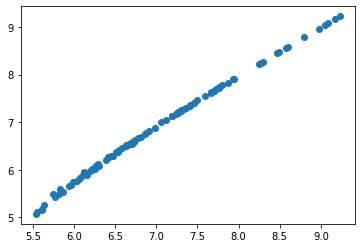

In [119]:
plt.scatter(gm_fold1_cbp_w_bias_pred_cts, tt_gm_fold1_cbp_w0_bias_pred_cts)


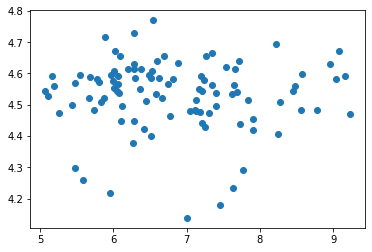

In [120]:
plt.scatter(gm_fold1_cbp_wo_bias_pred_cts, tt_bias_pred_cts)


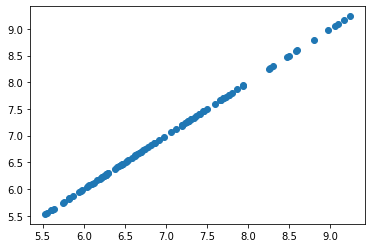

In [121]:
plt.scatter(gm_fold1_cbp_w_bias_pred_cts,
            tf.reduce_logsumexp([gm_fold1_cbp_wo_bias_pred_cts, gm_fold1_bias_pred_cts], axis=0))

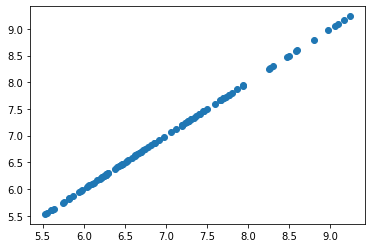

In [122]:
plt.scatter(gm_fold1_cbp_w_bias_pred_cts,
            np.log(np.exp(gm_fold1_cbp_wo_bias_pred_cts)+np.exp(gm_fold1_bias_pred_cts)))

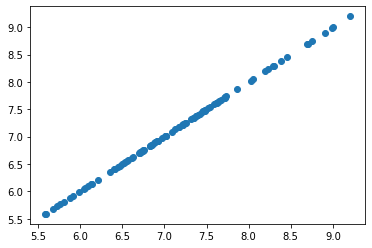

In [123]:
plt.scatter(other_cbp_w_bias_pred_cts,
            np.log(np.exp(other_cbp_wo_bias_pred_cts)+np.exp(other_bias_pred_cts)))

In [124]:
gm_fold1_cbp_w_bias_model.get_layer("model_wo_bias").get_layer('wo_bias_bpnet_logcount_predictions').weights[0]

<tf.Variable 'wo_bias_bpnet_logcount_predictions/kernel:0' shape=(512, 1) dtype=float32, numpy=
array([[ 2.54747178e-02],
       [ 1.65278077e-01],
       [-2.30199754e-01],
       [ 1.23972006e-01],
       [-1.03003100e-01],
       [ 1.70733419e-03],
       [-1.08026333e-01],
       [ 1.80514008e-01],
       [ 4.81584787e-01],
       [-3.30010653e-02],
       [-5.58572263e-02],
       [ 5.47922682e-04],
       [-1.97375759e-01],
       [ 1.35203913e-01],
       [-1.02348588e-01],
       [ 2.22668543e-01],
       [-9.35263485e-02],
       [-4.92962673e-02],
       [ 2.17025012e-01],
       [ 1.29099771e-01],
       [ 6.23422153e-02],
       [ 1.06321625e-01],
       [ 1.60151646e-01],
       [ 9.74687412e-02],
       [-2.25075081e-01],
       [-1.50992665e-02],
       [ 2.08644271e-01],
       [-1.26724109e-01],
       [ 5.14989316e-01],
       [-1.31125646e-02],
       [-7.50690978e-03],
       [-1.39028570e-02],
       [ 6.43530190e-01],
       [ 8.31427425e-02],
       [ 6.28838763e

In [125]:
gm_fold1_cbp_wo_bias_model.get_layer('wo_bias_bpnet_logcount_predictions').weights[0]

<tf.Variable 'wo_bias_bpnet_logcount_predictions/kernel:0' shape=(512, 1) dtype=float32, numpy=
array([[ 2.54747178e-02],
       [ 1.65278077e-01],
       [-2.30199754e-01],
       [ 1.23972006e-01],
       [-1.03003100e-01],
       [ 1.70733419e-03],
       [-1.08026333e-01],
       [ 1.80514008e-01],
       [ 4.81584787e-01],
       [-3.30010653e-02],
       [-5.58572263e-02],
       [ 5.47922682e-04],
       [-1.97375759e-01],
       [ 1.35203913e-01],
       [-1.02348588e-01],
       [ 2.22668543e-01],
       [-9.35263485e-02],
       [-4.92962673e-02],
       [ 2.17025012e-01],
       [ 1.29099771e-01],
       [ 6.23422153e-02],
       [ 1.06321625e-01],
       [ 1.60151646e-01],
       [ 9.74687412e-02],
       [-2.25075081e-01],
       [-1.50992665e-02],
       [ 2.08644271e-01],
       [-1.26724109e-01],
       [ 5.14989316e-01],
       [-1.31125646e-02],
       [-7.50690978e-03],
       [-1.39028570e-02],
       [ 6.43530190e-01],
       [ 8.31427425e-02],
       [ 6.28838763e

In [126]:
vals1 = gm_fold1_cbp_w_bias_model.get_layer("concatenate").predict(segs)
vals2 = gm_fold1_cbp_w_bias_model.get_layer("logcount_predictions").predict(segs)

AttributeError: 'Concatenate' object has no attribute 'predict'

In [127]:
temp1 = gm_fold1_cbp_w_bias_model.get_layer("concatenate").output
#counts_output_without_bias = model.get_layer("wo_bias_bpnet_logcount_predictions").output
temp1 = Model(inputs=gm_fold1_cbp_w_bias_model.inputs,outputs=temp1)

In [128]:
x1 = temp1.predict(seqs)[:,0]
x2 = temp1.predict(seqs)[:,1]

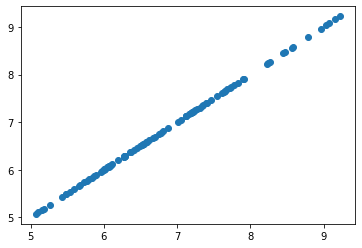

In [129]:
plt.scatter(x1, tt_gm_fold1_cbp_w0_bias_pred_cts)

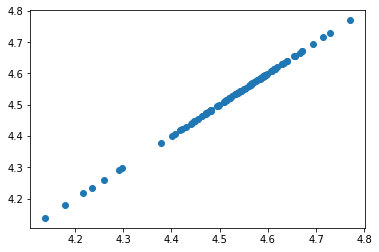

In [130]:
plt.scatter(x2, tt_bias_pred_cts)

In [131]:
x1

array([6.269737 , 5.1568193, 6.619321 , 6.278672 , 6.009707 , 8.245915 ,
       5.0693717, 9.158477 , 5.7696815, 6.286405 , 6.0190706, 6.0657396,
       6.373196 , 6.1957517, 8.782664 , 7.1646924, 6.5810633, 5.97025  ,
       6.541176 , 7.7311373, 7.6876855, 6.4128013, 6.5313005, 7.340529 ,
       5.4318104, 6.283879 , 5.2595077, 5.4807897, 6.514063 , 8.578268 ,
       5.1012464, 7.266956 , 6.3618026, 7.6352324, 7.7723446, 6.294034 ,
       7.4017553, 7.306595 , 8.963101 , 6.668815 , 6.8783574, 6.5141096,
       6.2755075, 7.5387564, 7.2109017, 7.901084 , 7.3985147, 6.111161 ,
       7.120071 , 5.8916698, 5.8662295, 6.08364  , 5.1830964, 7.0055137,
       5.665992 , 8.562015 , 7.4602265, 7.2042646, 6.8104854, 5.5909257,
       6.0987134, 9.226369 , 5.5380816, 5.481528 , 7.185232 , 6.048334 ,
       7.6179585, 6.003674 , 7.6504436, 8.473102 , 5.8320804, 6.590953 ,
       6.0677857, 5.801167 , 8.447797 , 7.9099956, 7.246129 , 7.122455 ,
       7.1936383, 7.235542 , 7.046437 , 8.273728 , 

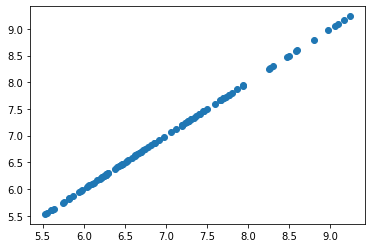

In [132]:
plt.scatter(tf.reduce_logsumexp([x1, x2], axis=0),gm_fold1_cbp_w_bias_pred_cts)